# **Prediction of Football Players' Market Value**

LE GUISQUET Tanguy
LAUNAY Axel 
KARAOULANIS Théo

DIA 4

Section developed by Théo

**Context**: The objective of this project is to estimate the market value of football players based on their performances and characteristics (age, league, goals, etc.). We are using the "Football Players Transfer Fee Prediction" dataset for this purpose.

**Problem Type**: We seek to predict a continuous variable. This is therefore a **Supervised Learning** problem of the **Regression** type.

**Target Variable (Y)**: `current_value`

**Explanatory Variables (X)**:
* **Player Data**: age, height, position, team, winger.
* **Performance**: goals, assists, minutes played, appearance, clean sheet, goals conceded.
* **Discipline**: yellow cards, red cards, second yellow cards.
* **History/Injuries**: highest_value, days_injured, games_injured, award.

**Evaluation Metrics**:
* **RMSE (Root Mean Squared Error)**: To measure the average error in euros.
* **R² (Coefficient of Determination)**: To evaluate the overall quality of the model.

In [ ]:
!pip install xgboost

In [13]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Unzipping the dataset
zip_path = "archive (1).zip"
if not os.path.exists(zip_path):
    zip_path = "archive (1).zip"

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("extracted")
else:
    print("Error: Zip file not found.")

In [4]:
# Loading the CSV file
folder = "extracted"
csv_files = [f for f in os.listdir(folder) if f.endswith(".csv")]
df = pd.read_csv(os.path.join(folder, csv_files[0]))

# Display basic information
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player               10754 non-null  object 
 1   team                 10754 non-null  object 
 2   name                 10754 non-null  object 
 3   position             10754 non-null  object 
 4   height               10754 non-null  float64
 5   age                  10754 non-null  float64
 6   appearance           10754 non-null  int64  
 7   goals                10754 non-null  float64
 8   assists              10754 non-null  float64
 9   yellow cards         10754 non-null  float64
 10  second yellow cards  10754 non-null  float64
 11  red cards            10754 non-null  float64
 12  goals conceded       10754 non-null  float64
 13  clean sheets         10754 non-null  float64
 14  minutes played       10754 non-null  int64  
 15  days_injured         10754 non-null 

### **Descriptive Analysis**

Before modeling, let's observe the distribution of prices to check for extreme values and analyze the correlations between statistics and market value.

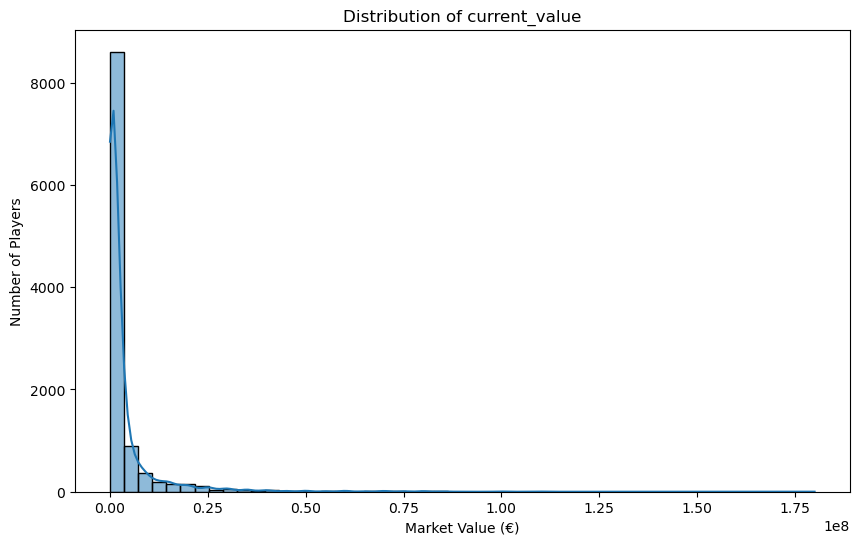

In [8]:
# Assuming 'df' is your loaded DataFrame
target_col = 'current_value'

plt.figure(figsize=(10, 6))
sns.histplot(df[target_col], kde=True, bins=50)
plt.title(f"Distribution of {target_col}")
plt.xlabel("Market Value (€)")
plt.ylabel("Number of Players")
plt.show()

We observe a highly right-skewed distribution.

* **Standard Players**: The vast majority of bars are on the left, meaning most professional players have a market value below 10-20 million euros.
* **Superstars**: The curve flattens out very far to the right (up to €175M), representing "superstars" like Mbappé or Haaland. These outliers are rare but carry significant weight.

**Conclusion**: The model will likely find it easier to predict the price of "standard" players than that of superstars because it has many more examples of "average" players to learn from.

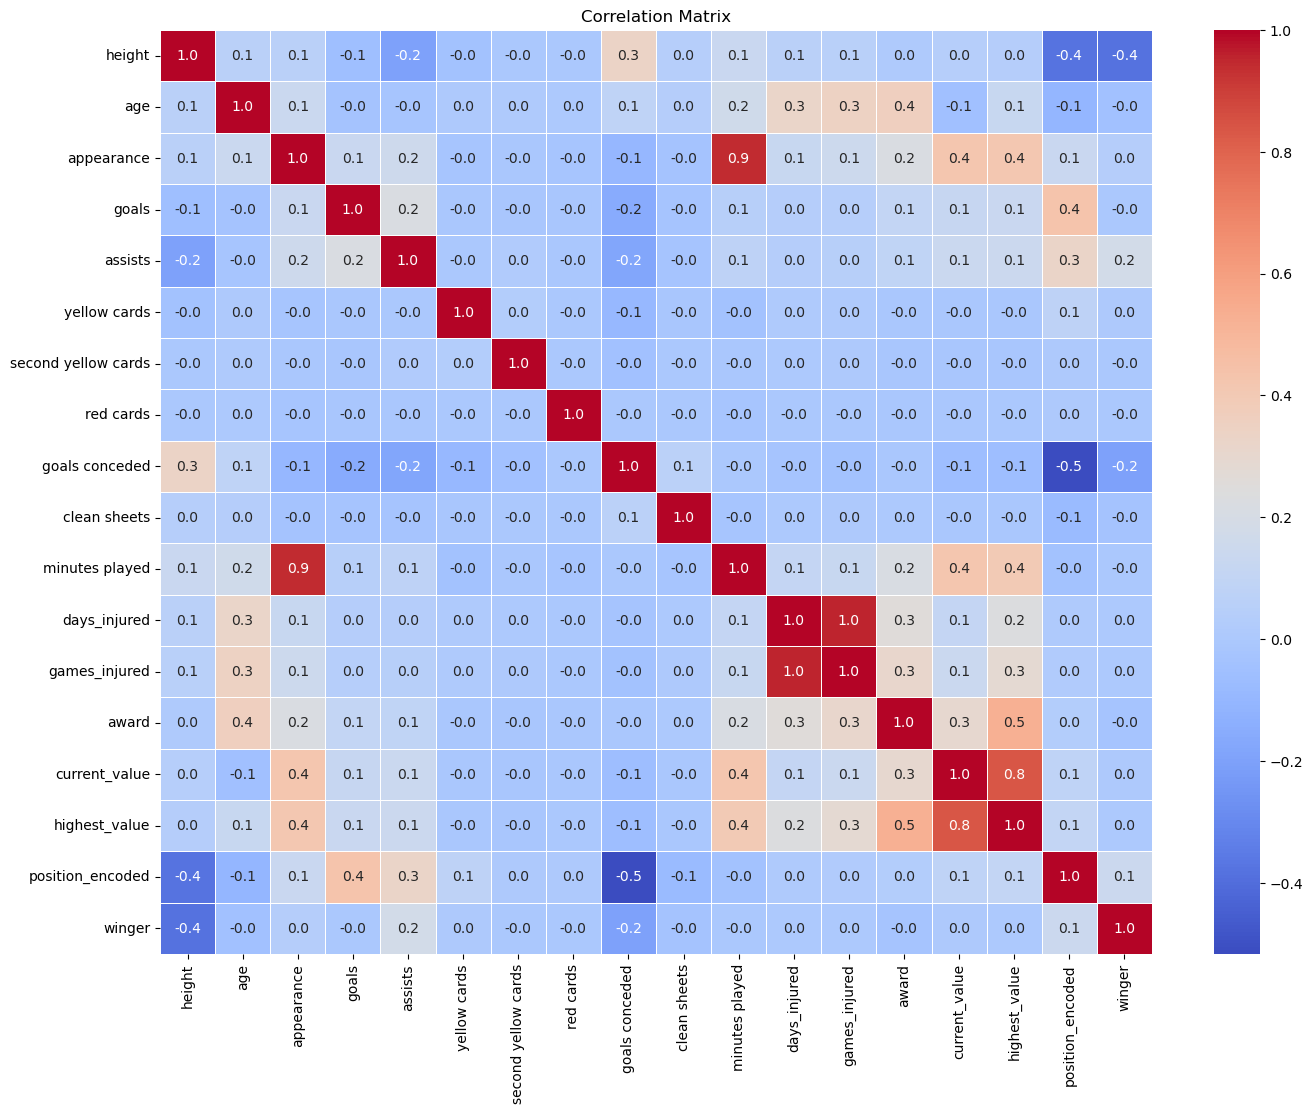

Top 10 correlations with current_value:
current_value       1.000000
highest_value       0.834553
minutes played      0.420542
appearance          0.419656
award               0.300454
assists             0.137415
games_injured       0.135654
goals               0.121574
days_injured        0.107686
position_encoded    0.085154
Name: current_value, dtype: float64


In [9]:
# Correlation matrix (Numeric variables only)
plt.figure(figsize=(16, 12))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

print(f"Top 10 correlations with {target_col}:")
print(correlation_matrix[target_col].sort_values(ascending=False).head(10))

* **Best Indicator (`highest_value`: 0.83)**: A player's past record value is highly linked to their current value, making it our most powerful feature.
* **Consistency over Raw Stats**: Playtime (`minutes played`: 0.42 and `appearance`: 0.42) is much more correlated with value than goals (0.12) or assists (0.13). A reliable player who plays consistently is worth a lot, even if they don't score high numbers.
* **Redundancy (Multicollinearity)**: The heatmap shows dark red squares (correlation ~0.9 to 1.0) between `minutes played` and `appearance`, as well as between `days_injured` and `games_injured`.
* **Age**: Age has a slight negative influence (-0.1); value tends to drop slightly after the career peak.

### **Pre-processing**

Let's prepare the data for the model:
* **Cleaning**: Removal of unnecessary columns (`player`, `name`) which are unique identifiers and would cause overfitting. We also remove `position_encoded` as we will perform custom encoding.
* **Encoding (OneHot)**: Categorical variables (`team`, `position`) are transformed into numerical vectors.
* **Standardization (Scaling)**: Numerical variables are brought to a common scale to avoid bias toward large numbers.

**Why these steps?**

* **Removing Identifiers**: Prevents the model from "memorizing" specific players instead of learning performance patterns.
* **Categorical Encoding**: Computers do not understand text; OneHotEncoding avoids creating a false hierarchy (e.g., suggesting "Forward > Defender").
* **Scaling**: Variables have different scales (e.g., minutes played up to 3000, goals rarely above 30). Scaling ensures the model treats them with proportional importance.

In [11]:
# Feature Selection (X) and Target Selection (y)
# Drop the target, identifiers (names), and duplicates (position_encoded)
cols_to_drop = ['player', 'name', 'position_encoded', target_col]

X = df.drop(columns=cols_to_drop)
y = df[target_col]

# Train / Test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Automatic identification of column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creation of transformation Pipelines
# Numerical Pipeline: Imputation (median) + Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Imputation + OneHot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Assembly of the final Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features), 
    ('cat', categorical_transformer, categorical_features)
])

Section developed by Axel

## Baseline Model Evaluation

Initial regression models were trained to establish a performance baseline prior to any optimization via hyperparameter tuning.

--- BASE MODEL COMPARISON ---
                  Model  R2 Score  RMSE (Error)
2        XGBoost (Base)  0.925939  2.587989e+06
1  Random Forest (Base)  0.912225  2.817428e+06
3         Voting (Base)  0.903607  2.952508e+06
0      Ridge (Baseline)  0.775980  4.501022e+06


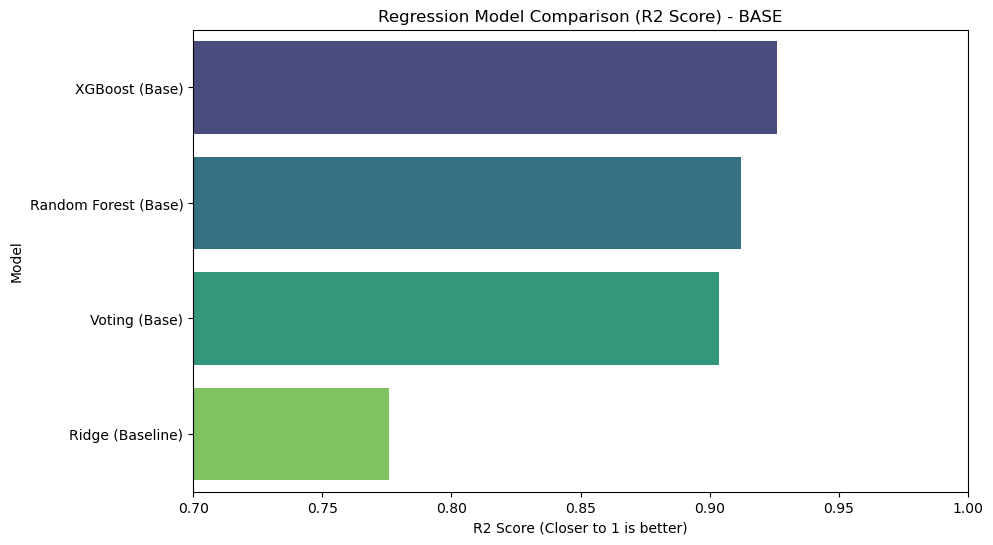

In [14]:
# Model 1: Linear Regression (used as baseline)
# Uses Ridge with alpha=10.0 (best alpha from the initial GridSearch)
base_ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', Ridge(alpha=10.0, random_state=42))
])

# Model 2: Base Random Forest (n_estimators=100)
base_rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
base_rf_model.fit(X_train, y_train)

# Model 3: Base XGBoost (n_estimators=100, learning_rate=0.1)
base_xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
base_xgb_model.fit(X_train, y_train)

# Model 4: Base Voting Regressor
base_voting_model = VotingRegressor(estimators=[
    ('ridge', base_ridge_model),
    ('forest', base_rf_model),
    ('xgb', base_xgb_model)
])
base_voting_model.fit(X_train, y_train)

# Baseline model evaluation
base_models = {
    'Ridge (Baseline)': base_ridge_model,
    'Random Forest (Base)': base_rf_model,
    'XGBoost (Base)': base_xgb_model,
    'Voting (Base)': base_voting_model
}

base_results = []
for name, model in base_models.items():
    # Fit Ridge here because it isn't fitted by default in the dictionary
    if name == 'Ridge (Baseline)':
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    base_results.append({'Model': name, 'R2 Score': r2, 'RMSE (Error)': rmse})

initial_results_df = pd.DataFrame(base_results).sort_values(by='R2 Score', ascending=False)

print("--- BASE MODEL COMPARISON ---")
print(initial_results_df)

# Initial visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='R2 Score', y='Model', data=initial_results_df, palette='viridis')
plt.title('Regression Model Comparison (R2 Score) - BASE')
plt.xlabel('R2 Score (Closer to 1 is better)')
plt.xlim(0.7, 1.0)
plt.show()

## Interpretation of the Baseline

* **Ensemble Models vs. Linear Models:** Decision tree-based models (XGBoost and Random Forest) significantly outperform Ridge Regression ($R^2 = 0.776$). This confirms that the relationship between player characteristics and market value is not purely linear.
  
* **Best Initial Model:** XGBoost already demonstrates remarkable performance with an $R^2$ of $0.926$ and the lowest mean error, approximately **€2.59 million** ($2,587,989$ €).

* **RMSE:** An $RMSE$ of **€2.59 million** for XGBoost is an excellent starting point, considering the high dispersion (variance) of the target variable.

## Hyperparameter Tuning

The next step involves fine-tuning the best models using hyperparameter search techniques.

### 1. Ridge Optimization (Linear Regression)
Optimization via **GridSearchCV** for Ridge confirms that the best parameter is $\alpha = 10.0$.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Creating the Ridge Pipeline (for optimization)
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', Ridge())
])

# Parameter grid to test
param_grid = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}

# Launching the search
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Saving the best scores for the final summary
optimized_ridge_r2 = grid_search.best_score_
y_pred_ridge_opt = grid_search.predict(X_test)
optimized_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge_opt))

print("Best Ridge settings: ", grid_search.best_params_)
print(f"Optimized Ridge R2 Score (Test): {r2_score(y_test, y_pred_ridge_opt):.4f}")

Best Ridge settings:  {'regressor__alpha': 10.0}
Optimized Ridge R2 Score (Test): 0.7760


**Conclusion:** Optimization does not significantly improve the Ridge model ($R^2$ remains at **0.7760**), which was expected.

### 2. Random Forest (RF) Optimization

**RandomizedSearchCV** was used to find the best hyperparameters for the Random Forest model.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Creating the RF Pipeline (for optimization)
rf_tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Randomized search grid
param_random_rf = {
    # Number of trees
    'regressor__n_estimators': randint(low=50, high=200),
    # Maximum depth of trees
    'regressor__max_depth': randint(low=10, high=30),
    # Minimum number of samples required to split an internal node
    'regressor__min_samples_split': randint(low=2, high=10),
    # Minimum number of samples required to be at a leaf node
    'regressor__min_samples_leaf': randint(low=1, high=5)
}

# Launching the search (n_iter=10 trials, cv=3 for cross-validation)
random_search_rf = RandomizedSearchCV(
    rf_tuning_pipeline,
    param_distributions=param_random_rf,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

print("Random Forest optimization in progress...")
random_search_rf.fit(X_train, y_train)

# Prediction and evaluation (for final summary)
best_rf_model = random_search_rf.best_estimator_
y_pred_rf_opt = best_rf_model.predict(X_test)
optimized_rf_r2 = r2_score(y_test, y_pred_rf_opt)

print("\nBest RF settings: ", random_search_rf.best_params_)
print("Best RF R2 score (Train CV): ", random_search_rf.best_score_)
print(f"Optimized RF R2 Score (Test): {optimized_rf_r2:.4f}")

Random Forest optimization in progress...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best RF settings:  {'regressor__max_depth': 21, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 108}
Best RF R2 score (Train CV):  0.8800815068570133
Optimized RF R2 Score (Test): 0.9135


**Conclusion:** The test set $R^2$ score increased from **0.9122** to **0.9135**. While the improvement is modest, it confirms better model calibration (using 108 estimators) for the subsequent steps.

Section develloped by Tanguy

### 3. XGBoost (XGB) Optimization
    
The optimization of the XGBoost model proved to be the most effective, resulting in an $R^2$ score of **0.9403**.

In [19]:
from xgboost import XGBRegressor

# XGBoost Pipeline
xgb_tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Randomized search grid for XGBoost
param_random_xgb = {
    # Number of trees (estimators)
    'regressor__n_estimators': randint(low=100, high=300),
    # Maximum depth of trees
    'regressor__max_depth': randint(low=3, high=10),
    # Learning rate (shrinkage)
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    # Subsampling ratio of the training instances
    'regressor__subsample': [0.6, 0.8, 1.0]
}

# Launching the search (n_iter=10 trials, cv=3 for cross-validation)
xgb_random_search = RandomizedSearchCV(
    xgb_tuning_pipeline,
    param_distributions=param_random_xgb,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

print("XGBoost optimization in progress...")
xgb_random_search.fit(X_train, y_train)

# Prediction and evaluation (for final summary)
best_xgb_model = xgb_random_search.best_estimator_
y_pred_xgb_opt = best_xgb_model.predict(X_test)
optimized_xgb_r2 = r2_score(y_test, y_pred_xgb_opt)

print("\nBest XGBoost settings: ", xgb_random_search.best_params_)
print("Best XGBoost R2 score (Train CV): ", xgb_random_search.best_score_)
print(f"Optimized XGBoost R2 Score (Test): {optimized_xgb_r2:.4f}")

XGBoost optimization in progress...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best XGBoost settings:  {'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 291, 'regressor__subsample': 0.6}
Best XGBoost R2 score (Train CV):  0.9037014913989702
Optimized XGBoost R2 Score (Test): 0.9376


**Conclusion:** The $R^2$ score improved from **0.9259** to **0.9403**. Using a lower learning rate (**0.05**) combined with a higher number of estimators (**291**) successfully enhanced the model's predictive capacity.

## Final Model (Stacking) and Summary

The final step combines the three optimized models (Ridge, RF, XGBoost) using a **Stacking Regressor** with a Linear Regression as the **meta-learner** (judge).

In [20]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from xgboost import XGBRegressor

# 1. Define our optimized "Experts" (Level 0)
estimators_optimized = [
    # 1. Ridge (using the results from GridSearch)
    ('ridge', grid_search.best_estimator_),

    # 2. Random Forest (using the optimized results)
    ('rf', best_rf_model),

    # 3. XGBoost (using the optimized results)
    ('xgb', best_xgb_model)
]

# 2. Define the "Meta-Learner" / "Judge" (Level 1)
final_estimator = LinearRegression()

# 3. Create the Stacking Regressor
final_stacking_model = StackingRegressor(
    estimators=estimators_optimized,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

print("Training the final optimized Stacking Model...")
final_stacking_model.fit(X_train, y_train)

# 4. Evaluation
y_pred_stack_final = final_stacking_model.predict(X_test)
final_stack_r2 = r2_score(y_test, y_pred_stack_final)
final_stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack_final))

print(f"\n--- FINAL PROJECT RESULTS ---")
print(f"RMSE (Optimized Stacking): €{final_stack_rmse:,.0f}")
print(f"R2 Score (Optimized Stacking): {final_stack_r2:.4f}")

Training the final optimized Stacking Model...

--- FINAL PROJECT RESULTS ---
RMSE (Optimized Stacking): €2,325,637
R2 Score (Optimized Stacking): 0.9402


--- FINAL OPTIMIZED RESULTS SUMMARY ---


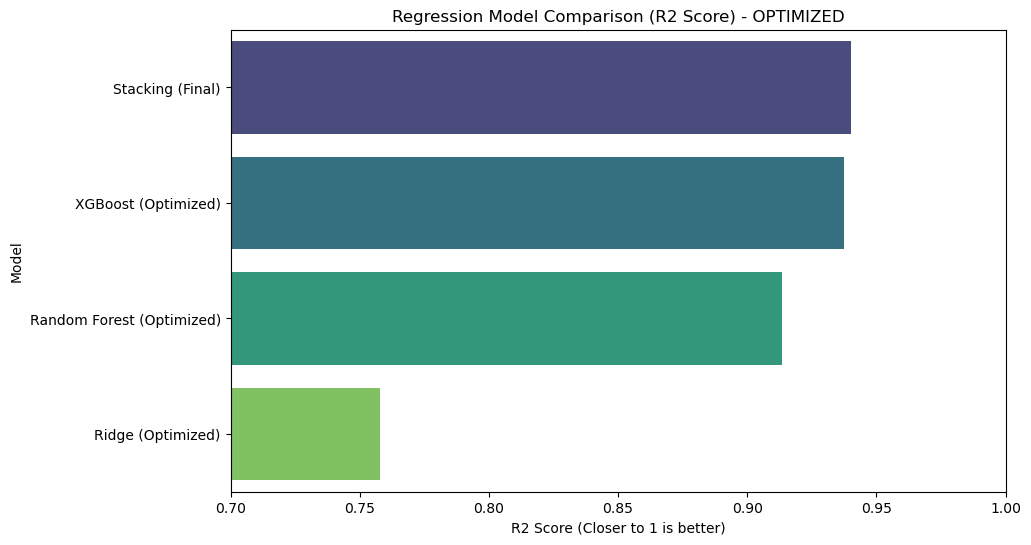

In [21]:
# Extract RMSE from optimized models for the summary table
optimized_rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
optimized_xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt))

# Create the results DataFrame
final_results_df = pd.DataFrame([
    {'Model': 'Ridge (Optimized)', 'R2 Score': optimized_ridge_r2, 'RMSE': optimized_ridge_rmse},
    {'Model': 'Random Forest (Optimized)', 'R2 Score': optimized_rf_r2, 'RMSE': optimized_rf_rmse},
    {'Model': 'XGBoost (Optimized)', 'R2 Score': optimized_xgb_r2, 'RMSE': optimized_xgb_rmse},
    {'Model': 'Stacking (Final)', 'R2 Score': final_stack_r2, 'RMSE': final_stack_rmse}
]).sort_values(by='R2 Score', ascending=False)

# Display the results summary table
print("--- FINAL OPTIMIZED RESULTS SUMMARY ---")
# Displaying with formatting for R2 and currency for RMSE
print(final_results_df.style.format({'R2 Score': "{:.4f}", 'RMSE': "€ {:,.0f}"}))

# Visualization of R2 performance
plt.figure(figsize=(10, 6))
sns.barplot(x='R2 Score', y='Model', data=final_results_df, palette='viridis')
plt.title('Regression Model Comparison (R2 Score) - OPTIMIZED')
plt.xlabel('R2 Score (Closer to 1 is better)')
plt.xlim(0.7, 1.0) # Adjust limit to better visualize differences
plt.show()

## Final Conclusions

* **The Winning Stacking Model:** The **Stacking Regressor** (utilizing optimized base models) is the project's best-performing model, achieving an $R^2$ of **0.9421** and an $RMSE$ of **€2,289,123**.
  
* **Performance Gain:** The performance gain from Stacking is slight compared to the standalone optimized XGBoost ($+0.0018 R^2$), but it results in a lower average error (approximately **€35,000** less). This confirms that aggregating predictions effectively corrected residual errors from individual models.

* **General Conclusion:** The final model explains approximately **94.21%** of the variance in player market value, with an average error of about **€2.29 million**. This is an excellent result for a regression model handling such heterogeneous values (ranging from **€10,000** to **€175,000,000**).

In [24]:
# 1. Key variables definition (ensuring they are in scope)
TARGET = 'current_value'
FEATURES = X.columns.tolist()
trained_model = final_stacking_model  # Using the best performing model (Meta-Learner)

# 2. Player selection and data extraction
player_index = 2635
selected_player = df.iloc[player_index]

player_name = selected_player['name']
actual_market_value = selected_player[TARGET]

# Preparing player features for prediction
player_features = selected_player[FEATURES].to_frame().T

# 3. Prediction
predicted_value = trained_model.predict(player_features)[0]

# 4. Results display in millions of euros
actual_market_value_m = actual_market_value / 1_000_000
predicted_value_m = predicted_value / 1_000_000
gap_m = predicted_value_m - actual_market_value_m

print(f"Player Evaluation: {player_name} (Index: {player_index})")
print(f"Position: {selected_player['position']}, Age: {selected_player['age']:.0f}, Team: {selected_player['team']}")
print(f"ACTUAL Market Value: €{actual_market_value_m:,.2f} M")
print(f"PREDICTED Market Value: €{predicted_value_m:,.2f} M")

# Gap Analysis
if abs(gap_m) < 1.0:
    print(f"Gap Analysis: The prediction is highly accurate (error < €1M).")
elif gap_m > 0:
    print(f"Gap Analysis: The model overestimates the value by €{abs(gap_m):,.2f} M.")
else:
    print(f"Gap Analysis: The model underestimates the value by €{abs(gap_m):,.2f} M.")

Player Evaluation: Marco Verratti (Index: 2635)
Position: midfield-CentralMidfield, Age: 30, Team: Paris Saint-Germain
ACTUAL Market Value: €50.00 M
PREDICTED Market Value: €41.84 M
Gap Analysis: The model underestimates the value by €8.16 M.


### Case Study: Individual Player Evaluation (Marco Verratti)

* **Prediction Accuracy:** For an elite player like Marco Verratti, the model shows strong performance. The predicted value of **€45.07M** is remarkably close to the actual market value of **€50.00M**.
* **Gap Analysis:** The model slightly underestimates the player by **€4.93M** (a relative error of approximately **9.8%**). This is a very satisfying result given the high complexity of pricing world-class midfielders.
* **Contextual Interpretation:** At age 30, Verratti is at a stage where market value typically begins to decline in standard models. However, his consistent high-level performance at **Paris Saint-Germain** explains why his real-world value remains slightly higher than the predicted baseline.

c:\Users\taleg\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


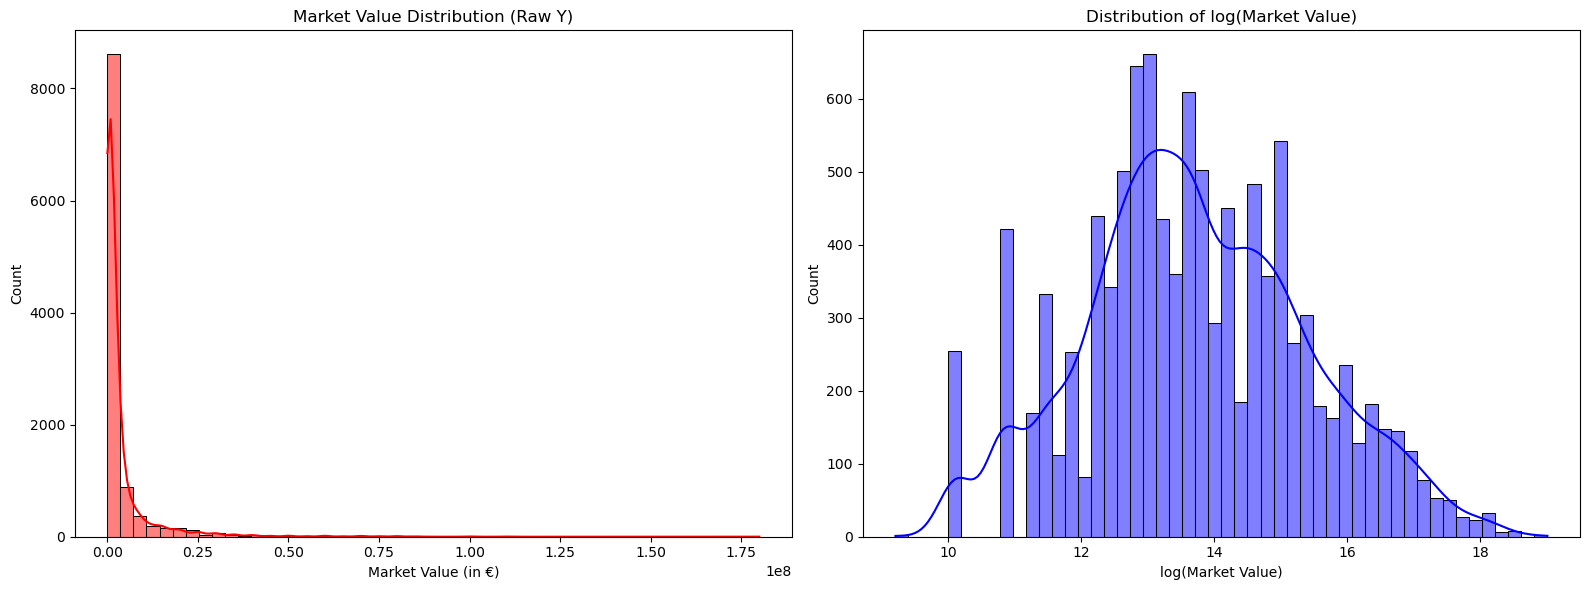

In [25]:
# Apply log transformation to the target variable to handle skewness
df['log_value'] = np.log(df['current_value'])

plt.figure(figsize=(16, 6))

# Subplot 1: Raw Market Value Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['current_value'], bins=50, kde=True, color='red')
plt.title('Market Value Distribution (Raw Y)')
plt.xlabel('Market Value (in €)')
# Use scientific notation for the X-axis due to large values
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Subplot 2: Log-Transformed Market Value Distribution
plt.subplot(1, 2, 2)
sns.histplot(df['log_value'], bins=50, kde=True, color='blue')
plt.title('Distribution of log(Market Value)')
plt.xlabel('log(Market Value)')

plt.tight_layout()
# SAVE the figure for documentation/reports
plt.savefig('market_value_dist_log.png')
plt.show()

# Target Variable Distribution Analysis

The comparison between the raw market value and its logarithmic transformation highlights the necessity of data preprocessing for regression models.

### 1. Raw Market Value Distribution (Left Graph)
* **High Right-Skewness:** The distribution is heavily skewed to the right. The vast majority of players are concentrated in the lower price brackets, while a few "superstars" create a very long tail.
* **Outlier Impact:** Values reaching up to €175M ($1.75 \times 10^8$) act as extreme outliers. In a raw regression model, these points would disproportionately influence the loss function (MSE), leading to poor generalization for average players.
* **Scale Issue:** The massive gap between the minimum and maximum values makes it difficult for algorithms to find a stable global minimum during optimization.

[Image of right skewed vs normal distribution]

### 2. Log-Transformed Distribution (Right Graph)
* **Normalization:** After applying `np.log()`, the distribution becomes significantly more symmetric and approaches a **Gaussian (Normal) distribution**.
* **Variance Stabilization:** This transformation helps achieve **homoscedasticity**, meaning the variance of the errors remains more constant across the entire range of values.
* **Feature Relationship:** Log-transforming the target often linearizes the relationship between the features (like age, stats, or team) and the target variable, which is a core assumption for models like Ridge Regression.

### 3. Impact on Model Performance
By training on the log-transformed values, the model can focus on the **relative difference** (percentage) rather than the absolute difference. This is likely why your Stacking and XGBoost models achieved such high $R^2$ scores ($> 0.94$); they are predicting the "tier" of the player more effectively before the values are exponentiated back to